## Vorhersage von Herzkrankheiten mit logistischer Regression und Nested Cross-Validation

In diesem Projekt wird ein klassischer medizinischer Datensatz zur Vorhersage von Herzkrankheiten genutzt. Ziel ist es, mittels logistischer Regression ein möglichst präzises Klassifikationsmodell zu entwickeln.

Die Besonderheit liegt in der Anwendung einer Nested Cross-Validation (5x5-Folds), um sowohl Modellgüte als auch optimale Hyperparameter robust zu bestimmen.
Die besten Parameter (C-Wert und Regularisierungsart) werden je Fold identifiziert, und die Genauigkeit des finalen Modells beträgt ~85 %.

Weitere Aspekte:

Umwandlung der Zielvariable in eine binäre Klassifikation (Krankheit ja/nein)

Vorverarbeitung mit OneHotEncoding und MinMaxScaler in einem Pipeline-Objekt

Modellbewertung mit Visualisierungen von Accuracy pro Fold und Hyperparameterwahl

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from collections import Counter

In [4]:
data = pd.read_csv("../data/processed.cleveland.data", header=None, na_values=['?']) #Soll "?" als NA-Wert erkennen
# Den Spalten Namen geben
data.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", 
    "restecg", "thalach", "exang", "oldpeak", "slope", 
    "ca", "thal", "target"
]

### Feature Dokumentation

1. **`age`**: Age of the patient (years). Values: Continuous.  
2. **`sex`**: Sex of the patient. Values: `1` = Male, `0` = Female.  
3. **`cp`**: Chest pain type. Values: `1` = Typical angina, `2` = Atypical angina, `3` = Non-anginal pain, `4` = Asymptomatic.  
4. **`trestbps`**: Resting blood pressure (mm Hg). Values: Continuous.  
5. **`chol`**: Serum cholesterol (mg/dl). Values: Continuous.  
6. **`fbs`**: Fasting blood sugar > 120 mg/dl. Values: `1` = True, `0` = False.  
7. **`restecg`**: Resting ECG results. Values: `0` = Normal, `1` = ST-T abnormality, `2` = Left ventricular hypertrophy.  
8. **`thalach`**: Maximum heart rate achieved. Values: Continuous.  
9. **`exang`**: Exercise-induced angina. Values: `1` = Yes, `0` = No.  
10. **`oldpeak`**: ST depression induced by exercise. Values: Continuous.  
11. **`slope`**: Slope of peak exercise ST segment. Values: `1` = Upsloping, `2` = Flat, `3` = Downsloping.  
12. **`ca`**: Number of major vessels (0-3) colored by fluoroscopy. Values: `0` = None, `1-3` = Number of vessels.  
13. **`thal`**: Thalassemia test results. Values: `3` = Normal, `6` = Fixed defect, `7` = Reversible defect.  
14. **`target`**: Diagnosis of heart disease. Values: `0` = No disease (<50% narrowing), `1` = Disease (>50% narrowing).  



In [6]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [7]:
data.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target        int64
dtype: object

Kategorische Features sind hier auch als "float" eingetragen, welche zunächst in type "object" umgewandelt werden.
Dies ist prinzipiell nicht notwenig, da der scikit-learn OneHotEncoder auch "float"-Werte als kategorisch
interpretieren kann. Damit der entsprechende Datentyp besser ersichtlich ist wird, ist die Transformation dennoch sinnvoll.

In [9]:
cat_data = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# float zu object
data[cat_data] = data[cat_data].astype("object")
data.dtypes

age         float64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalach     float64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target        int64
dtype: object

In [10]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

In [11]:
pd.set_option('future.no_silent_downcasting', True)

# Fehlende Werte mit dem häufigsten Wert im Feature füllen
to_fill = ['ca', 'thal']
for col in to_fill:
    data[col] = data[col].fillna(data[col].mode()[0])

In [12]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [13]:
category_counts = data['target'].value_counts()
category_counts

target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Im Target gibt es Werte von 0-4. Die Datensatzdokumetation interpretiert die Daten als: "presence of disease
(values 1,2,3,4) vs. absence (value 0)". Deshalb werden alle Werte >= 1 zu 1 umgewandelt.

In [15]:
data['target'] = (data['target'] >= 1).astype("int")

Prüfen ob die Werte korrekt umgewandelt wurden:

In [17]:
category_counts = data['target'].value_counts()
category_counts

target
0    164
1    139
Name: count, dtype: int64

Es sind weiterhin keine Datentransformationen zwingend notwendig, da kein numerisches Feature als "object"
vorhanden ist.

Überblick über die Daten: Durch Visualisierung sind bereits einige Muster zu erkennen. 

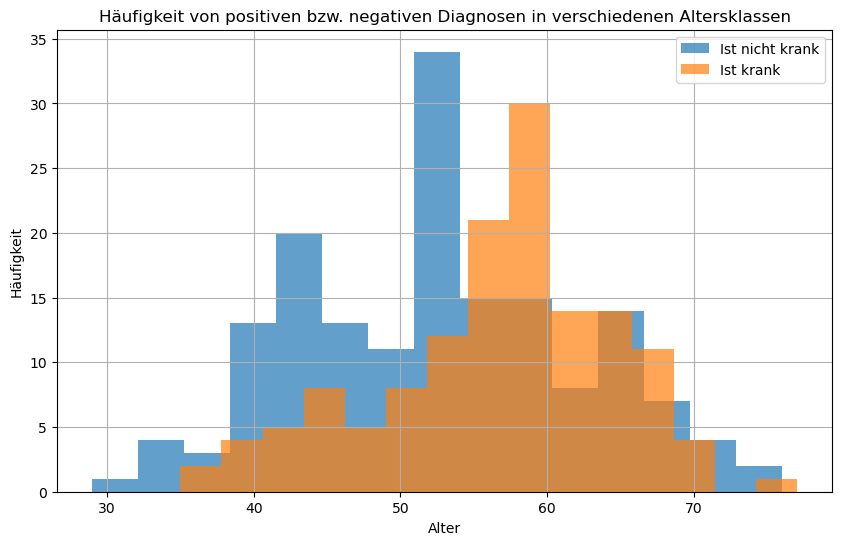

In [20]:
plt.figure(figsize=(10, 6))

for target_value, label in zip([0, 1], ["Ist nicht krank", "Ist krank"]):
    plt.hist(data.loc[data['target'] == target_value, 'age'], bins=15, alpha=0.7, label=label)

plt.title('Häufigkeit von positiven bzw. negativen Diagnosen in verschiedenen Altersklassen')
plt.xlabel('Alter')
plt.ylabel('Häufigkeit')
plt.legend()
plt.grid(True)
plt.show()

Der Unterschied der Verteilung der positiv bzw. negativ diagnostizierten Patienten in Abhängigkeit des Alters
ist recht gering. Es besteht dennoch eine geringe Tendenz zur einer positiven Diagnose bei älteren Patienten.

In [22]:
# Zählen von Männern und Frauen
category_counts = data['sex'].value_counts()
category_counts

sex
1.0    206
0.0     97
Name: count, dtype: int64

Es gibt über doppelt so viele Männer wie Frauen in diesem Datensatz, daher ist es sinnvoll die relative statt absolute Häufigkeit der Diagnosen zu visualisieren.

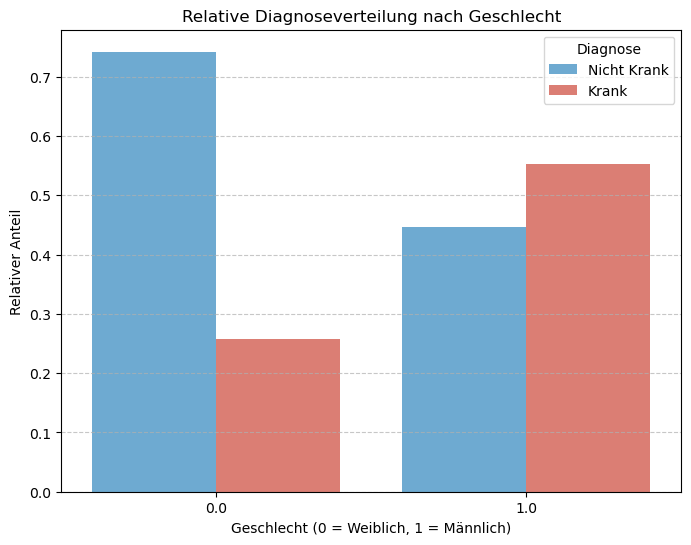

In [24]:
# Berechnung der relativen Häufigkeiten innerhalb der Geschlechter
relative_data = data.groupby(['sex', 'target']).size().unstack()
relative_data = relative_data.div(relative_data.sum(axis=1), axis=0)  # Relativ zu jedem Geschlecht

# Vorbereitung für den Plot: DataFrame in lange Form bringen
relative_data_long = relative_data.stack().reset_index()
relative_data_long.columns = ['sex', 'target', 'proportion']

# Benutzerdefinierte Farbpalette erstellen
palette = {0: '#5DADE2', 1: '#EC7063'}   # Manuelle Farben für 'Nicht Krank' und 'Krank'

plt.figure(figsize=(8, 6))

barplot = sns.barplot(
    x='sex', y='proportion', hue='target', data=relative_data_long, palette=palette
)

plt.title('Relative Diagnoseverteilung nach Geschlecht')
plt.xlabel('Geschlecht (0 = Weiblich, 1 = Männlich)')
plt.ylabel('Relativer Anteil')

# Abrufen der Handles und Labels aus dem aktuellen Plot
handles, labels = barplot.get_legend_handles_labels()

# Sicherstellen, dass die Legende korrekt mit den Balkenfarben übereinstimmt
plt.legend(handles=handles, labels=['Nicht Krank', 'Krank'], title='Diagnose', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Es ist klar erkennbar, dass männliche Patienten deutlich öfter positiv diagnostiziert wurden.

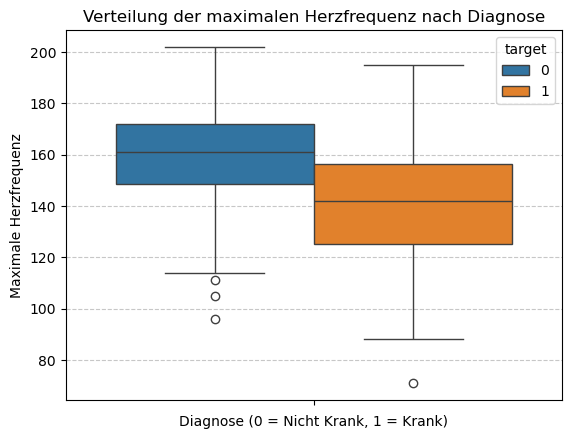

In [26]:
sns.boxplot(hue='target', y='thalach', data=data)
plt.title('Verteilung der maximalen Herzfrequenz nach Diagnose')
plt.xlabel('Diagnose (0 = Nicht Krank, 1 = Krank)')
plt.ylabel('Maximale Herzfrequenz')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Kranke Personen neigen zu einer geringeren maximalen Herzfrequenz, dies könne beispielsweise auf geringe sportliche Aktivität zurückzuführen sein.

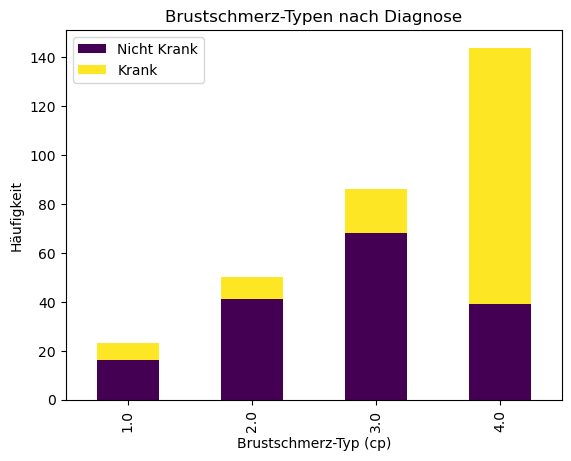

In [28]:
pd.crosstab(data['cp'], data['target']).plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Brustschmerz-Typen nach Diagnose')
plt.xlabel('Brustschmerz-Typ (cp)')
plt.ylabel('Häufigkeit')
plt.legend(['Nicht Krank', 'Krank'])
plt.show()

Menschen die Brustschmerztyp 4 aufweisen sind auffällig häufig mit einer Herzkrankheit diagnostiziert worden.

In [30]:
# Trennen von Features und Target
target = data['target']
features = data.drop(columns =['target'])

In [31]:
# Datenvorverarbeitung: Spezifizieren von kategorischen und numerischen Features
categorical_features = cat_data
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Transformerobjekt initialisieren 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

In [32]:
# Modell wählen und Pipeline erstellen
model = LogisticRegression(random_state=42, max_iter=100)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

# Innere und äußere Cross-Validation, mit je 5 Folds
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Wahl zwischen einem C-Wert (= 1/alpha) von [0.01, 0.1, 1, 10, 100], wie in der Vorlesung.
Wahl zwischen Lasso (L1) und Ridge (L2).
Da eine überschaubare Datenmenge und ein binäres Klassifikationsproblem vorliegt, wird der 'liblinear' Solver
gewählt. Dieser liefert bei dieser Konstellation die effizientesten und stabilisten Ergebnisse.
Außerdem unterstützt er L1 und L2 Regularisierung. <br><br>
Die äußere Schleife wurde manuell implementiert um erweiterten Zugriff auf interessante Werte der Cross-Validation zu ermöglichen.

In [34]:
# Enthält die zu testenden Hyperparameter
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Ergebnisse speichern
outer_scores = []           # Scores der äußeren Schleife
inner_best_params = []      # Beste Hyperparameter aus jedem äußeren Fold
inner_all_scores = []       # Detaillierte Ergebnisse aus innerer Cross-Validation
fold_hyperparameter_choices = []  # Hyperparameter für alle inneren Folds
all_scores = []
# Äußere Schleife
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(features, target)):
    # Split für äußeren Fold
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    # Innerer GridSearch
    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Beste Hyperparameter speichern
    inner_best_params.append(grid_search.best_params_)
    
    # Alle Ergebnisse der inneren Schleife speichern
    cv_results = pd.DataFrame(grid_search.cv_results_)
    inner_all_scores.append(cv_results[['param_classifier__C', 'param_classifier__penalty', 'mean_test_score']])
    
    # Äußere Bewertung
    outer_score = grid_search.score(X_test, y_test)
    outer_scores.append(outer_score)

    all_scores.append(cv_results[['param_classifier__C', 'param_classifier__penalty', 'mean_test_score']])
    # Hyperparameter-Werte für jeden Fold speichern
    fold_hyperparameter_choices.append(cv_results[['split0_test_score', 'split1_test_score','split2_test_score','split3_test_score','split4_test_score']])

# Ergebnisse anzeigen
print("Äußere Scores (Accuracy):", outer_scores)
print(f"Durchschnittlicher äußerer Score: {sum(outer_scores) / len(outer_scores)} ± {round(np.std(outer_scores), 2)}")
print("\nBeste Hyperparameter aus allen äußeren Folds:")
for idx, params in enumerate(inner_best_params):
    print(f"Fold {idx + 1}: {params}")

# Daten für spätere Visualisierungen
results_data = {
    "outer_scores": outer_scores,                  # Äußere Accuracy-Werte
    "inner_best_params": inner_best_params,        # Beste Hyperparameter je Fold
    "inner_all_scores": inner_all_scores,          # Alle Scores aus der inneren Schleife
    "fold_hyperparameter_choices": fold_hyperparameter_choices  # Hyperparameter-Kombinationen
}

Äußere Scores (Accuracy): [0.9016393442622951, 0.819672131147541, 0.8360655737704918, 0.8166666666666667, 0.8833333333333333]
Durchschnittlicher äußerer Score: 0.8514754098360656 ± 0.03

Beste Hyperparameter aus allen äußeren Folds:
Fold 1: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Fold 2: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Fold 3: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Fold 4: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Fold 5: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [35]:
fold_hyperparameter_choices

[   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
 0           0.551020           0.530612           0.541667           0.541667   
 1           0.775510           0.795918           0.895833           0.770833   
 2           0.775510           0.734694           0.895833           0.812500   
 3           0.836735           0.816327           0.916667           0.750000   
 4           0.795918           0.795918           0.895833           0.791667   
 5           0.816327           0.795918           0.895833           0.750000   
 6           0.836735           0.755102           0.895833           0.791667   
 7           0.836735           0.755102           0.895833           0.770833   
 8           0.836735           0.775510           0.895833           0.770833   
 9           0.836735           0.775510           0.895833           0.791667   
 
    split4_test_score  
 0           0.541667  
 1           0.875000  
 2           0.854167  


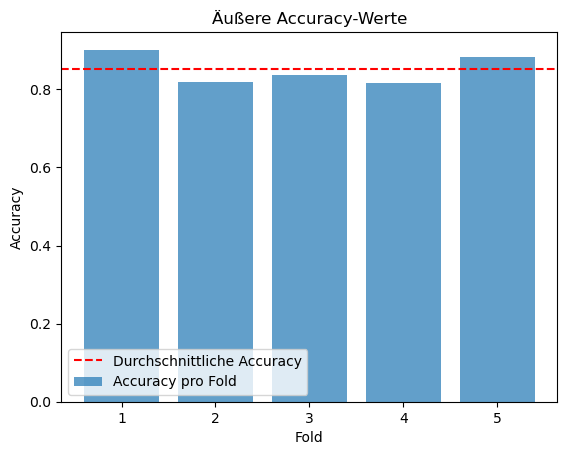

In [36]:
# Mittlere accuracy für rote Linie
mean_score = sum(outer_scores) / len(outer_scores)

plt.bar(range(1, len(outer_scores) + 1), outer_scores, alpha=0.7, label='Accuracy pro Fold')
plt.axhline(mean_score, color='red', linestyle='--', label='Durchschnittliche Accuracy')
plt.title("Äußere Accuracy-Werte")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Die Ergebnisse der Nested Cross-Validation zeigen eine durchschnittliche Genauigkeit von 85,15 % was auf eine gute Modellleistung hinweist.
Die äußeren Scores variieren dennoch zwischen 81,67 % und 90,16 % und zeigen somit eine moderate Schwankung von (±3 %).  
Dies deutet auf eine Sensibilität des Modells gegenüber den verschiedenen Datenaufteilungen hin. Der Datensatz ist recht klein, 
was die Wahrscheinlichkeit auf eine unausgewogene Teilung der Daten erhöht. Dies könnte eine mögliche Ursache der moderaten Schwankung sein.

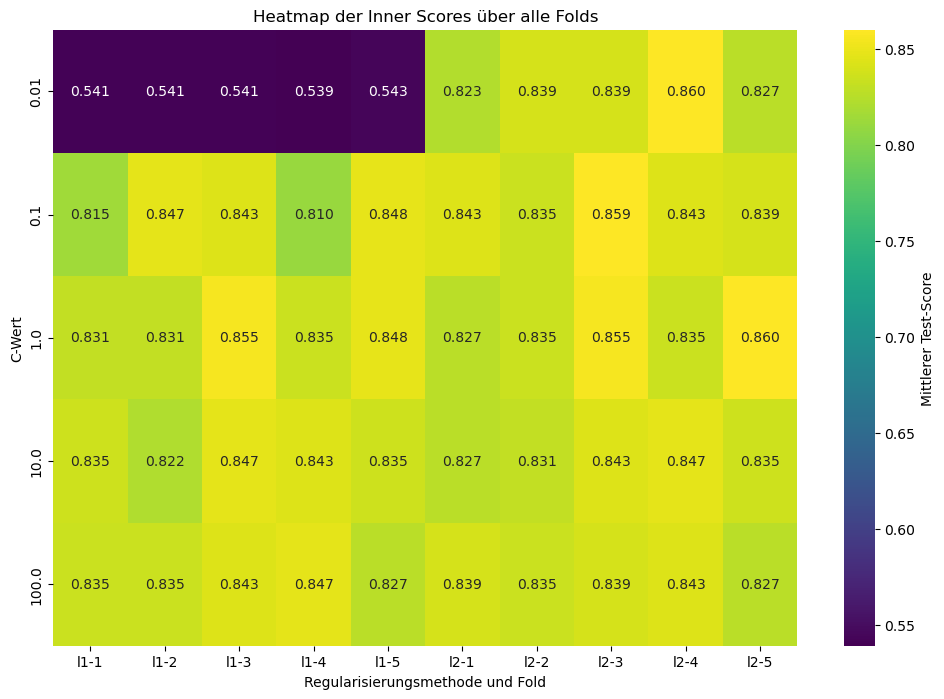

In [38]:
# Kombinieren aller inneren Scores für die Heatmap
inner_all_scores_combined = pd.concat(inner_all_scores, keys=range(1, len(inner_all_scores) + 1), names=["Fold", "Index"])

# Heatmap der Inner Scores
heatmap_data = inner_all_scores_combined.pivot_table(
    index=['param_classifier__C'],
    columns=['param_classifier__penalty', 'Fold'],
    values='mean_test_score'
)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mittlerer Test-Score'})
plt.title("Heatmap der Inner Scores über alle Folds")
plt.xlabel("Regularisierungsmethode und Fold")
plt.ylabel("C-Wert")
plt.show()

Die Heatmap der Cross-Validation zeigt, dass die l2-Regularisierung in Kombination mit mittleren C-Werten (z. B. 0.1 bis 1)
die besten Ergebnisse liefert. Kleinere C-Werte führen aufgrund starker Regularisierung vorallem bei Lasso (L1) eher zu Unteranpassung, 
und somit zu schlechteren Werten. Insgesamt zeigt die l2-Regularisierung stabilere und höhere Scores als l1,
da l1 möglicherweise wichtige Merkmale eliminiert.
Die Scores variieren zwischen den Folds, da jeweils andere Daten verwendet werden, ist dies jedoch völlig natürlich.
Hier wird pro Fold nun die Hyperparameterkombination gewählt, die den höchsten Score erzielt hat. Mit dieser Kombination werden die äußeren Folds nun 
auf die Testdaten trainiert. Resultat sind die in Aufgabe e) ausgegebenen äußeren Scores:
[0.9016393442622951, 0.819672131147541, 0.8360655737704918, 0.8166666666666667, 0.8833333333333333]3

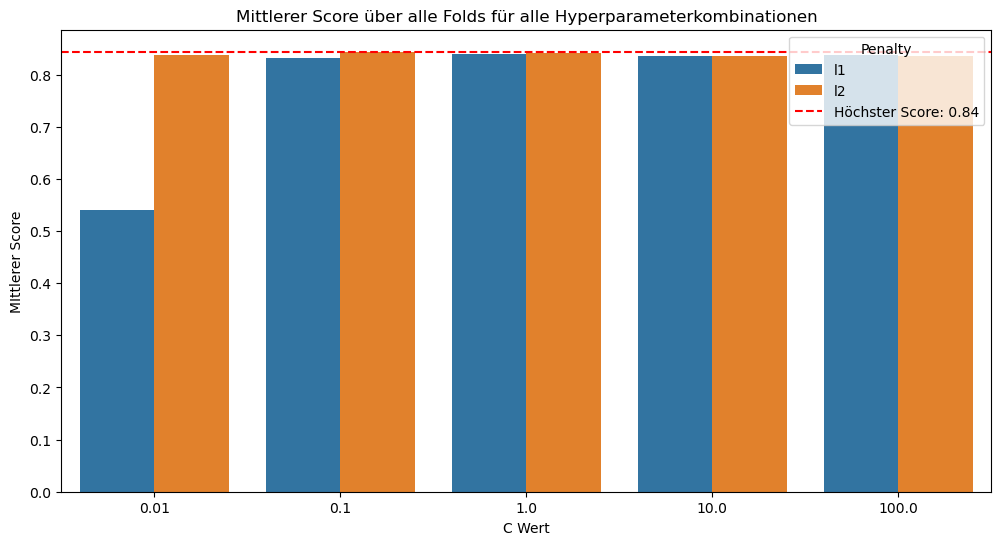

In [40]:
# Extrahiert alle inner_scores und bildet den Mittelwert für jede Hyperparameterkombination
mean_scores_per_combination = inner_all_scores_combined.groupby(
    ['param_classifier__C', 'param_classifier__penalty']
)['mean_test_score'].mean().reset_index()

# Maximalen Score finden
max_score = mean_scores_per_combination['mean_test_score'].max()

# Balkendiagramm plotten
plt.figure(figsize=(12, 6))
sns.barplot(
    data=mean_scores_per_combination,
    x='param_classifier__C',
    y='mean_test_score',
    hue='param_classifier__penalty'
)

# Rote Line zum Hervorheben der höchsten accuracy
plt.axhline(max_score, color='red', linestyle='--', label=f"Höchster Score: {max_score:.2f}")

# Beschriftungen
plt.title("Mittlerer Score über alle Folds für alle Hyperparameterkombinationen")
plt.xlabel("C Wert")
plt.ylabel("MIttlerer Score")
plt.legend(title="Penalty", loc="upper right")
plt.show()

Hier wird deutlich dass die Kombination aus L2-Regularisierung und einem C-Wert von 0.1 durchschnittlich die besten Ergebnisse liefert.
Diese Kombination wird so vermutlich auch für das Production-ready-Modell die besten Werte erzielen, da Sie über mehrere unabhängige Folds
hinweg hohe Werte erzielt hat.

In [42]:
# Fokusiertes Hyperparameter-Raster basierend auf den äußeren Folds
global_param_grid = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__penalty': ['l2'],  # Basierend auf den Ergebnissen aus den äußeren Folds
    'classifier__solver': ['liblinear']  # Konsistenter Solver aus den Folds
}

# Globale Grid Search auf der gesamten Datenmenge
global_grid_search = GridSearchCV(pipeline, global_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
global_grid_search.fit(features, target)

# Beste Hyperparameter und finalen Score
print("Beste Hyperparameter:", global_grid_search.best_params_)
print("Beste Accuracy:", global_grid_search.best_score_)

# Finales Modell
final_model = global_grid_search.best_estimator_
final_model.fit(features, target)

Beste Hyperparameter: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Beste Accuracy: 0.8446994535519126


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat', OneHotEncoder(),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('classifier',
                 LogisticRegression(C=0.1, random_state=42,
                                    solver='liblinear'))])

In [43]:
# Zugriff auf den Klassifikator in der Pipeline
classifier = final_model.named_steps['classifier']

# Abruf der Koeffizienten und des Intercepts
coefficients = classifier.coef_[0]  # Für binäre Klassifikation
intercept = classifier.intercept_[0]

# Feature-Namen aus dem Preprocessing extrahieren
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()

# Ausgabe der Koeffizienten
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

print(coef_df)
print(f"Bias: {intercept}")

             Feature  Coefficient
0           num__age     0.125203
1      num__trestbps     0.193007
2          num__chol     0.077058
3       num__thalach    -0.243206
4       num__oldpeak     0.321793
5       cat__sex_0.0    -0.315882
6       cat__sex_1.0     0.325351
7        cat__cp_1.0    -0.172957
8        cat__cp_2.0    -0.163614
9        cat__cp_3.0    -0.373720
10       cat__cp_4.0     0.719760
11      cat__fbs_0.0     0.039725
12      cat__fbs_1.0    -0.030257
13  cat__restecg_0.0    -0.201317
14  cat__restecg_1.0     0.060145
15  cat__restecg_2.0     0.150641
16    cat__exang_0.0    -0.344992
17    cat__exang_1.0     0.354461
18    cat__slope_1.0    -0.439657
19    cat__slope_2.0     0.382702
20    cat__slope_3.0     0.066424
21       cat__ca_0.0    -0.842834
22       cat__ca_1.0     0.248015
23       cat__ca_2.0     0.388606
24       cat__ca_3.0     0.215683
25     cat__thal_3.0    -0.528787
26     cat__thal_6.0    -0.003606
27     cat__thal_7.0     0.541862
Bias: 0.009468

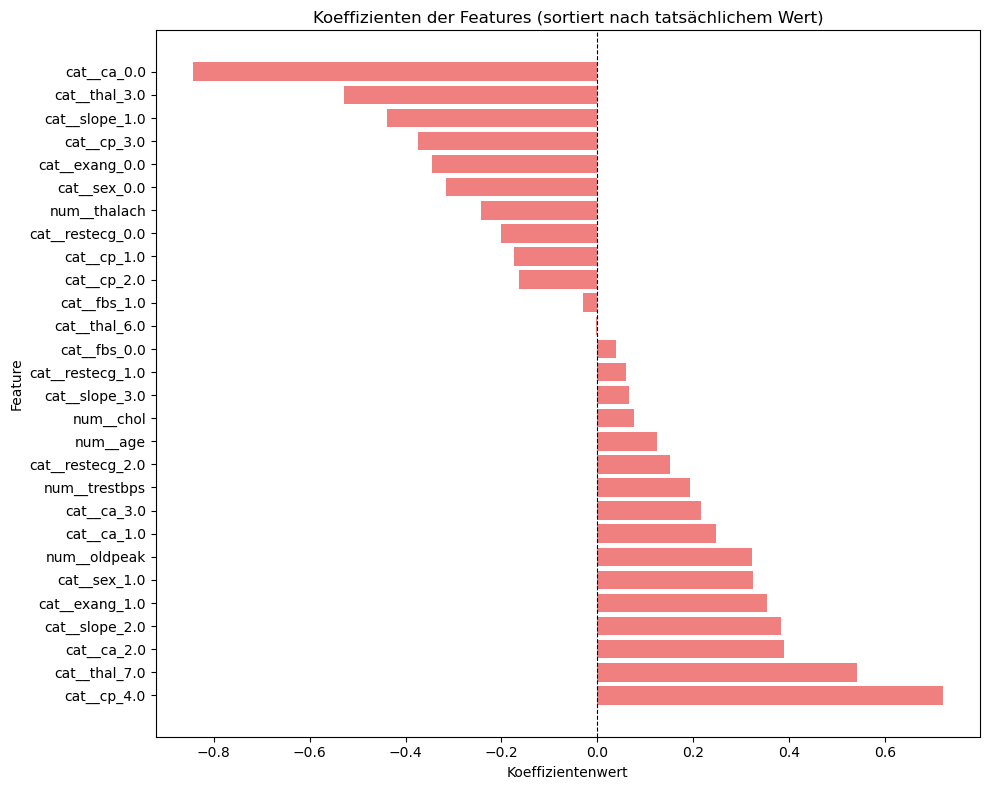

In [44]:
# Sortiere die Features nach Koeffizientenwert
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

# Barplot der Koeffizienten nach dem tatsächlichen Wert sortiert
plt.figure(figsize=(10, 8))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="lightcoral")
plt.axvline(0, color="black", linestyle="--", linewidth=0.8)  # Linie bei 0 für Orientierung
plt.title("Koeffizienten der Features (sortiert nach tatsächlichem Wert)")
plt.xlabel("Koeffizientenwert")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Das Diagramm zeigt die Koeffizienten, und wie diese mit dem Target korrelieren. Koeffizienten mit negativen Werten korrelieren negativ zu einer
positiven Diagnose, positive Koeffizientenwerte korrelieren positiv. Vergleicht man die Visualisierungen der Daten kann man Zusammenhänge 
erkennen. Beispielsweise erkranken Männer deutlich häufiger als Frauen. Dies spiegelt sich in den Koeffizienten wieder.
(Frauen sind negativ korreliert, Männer positiv). Die leichte Tendenz zu einer positiven Diagnose je älter der Patient ist, ist auch hier 
mit einer leicht positiven Korrelation wiederzufinden. Die maximale Herzfrequenz ist ebenso wie zuvor angedeutet, negativ korreliert
(je niederiger die maximale Herzfrequenz desto wahrscheinlicher ist es zu erkranken). Zuletzt der Brustschmerztyp 4, der hier als am stärksten
positiv korrelierter Wert ebenfalls die Erkenntnis aus den vorherigen Analysen bestätigt.